In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
# pd.set_option('display.max_rows', None)

import os

import numpy as np
import matplotlib.pyplot as plt

In [2]:
columns = ['cow_id', 'lactation_number', 'event', 'days_in_milk', 'date', 'remark', 'r', 't', 'b']

breedings = pd.read_csv(
    'sample/breedings.csv',
    header=0,
    names=columns,
    converters={'event': lambda x: x.strip()})

breedings.days_in_milk = pd.to_timedelta(breedings.days_in_milk, unit='days')
breedings.date = pd.to_datetime(breedings.date, errors='coerce')
breedings['calving_date'] = breedings.date - breedings.days_in_milk

breedings.drop(['remark', 'r', 't', 'b', 'days_in_milk', 'date'], axis=1, inplace=True)
breedings = breedings.drop_duplicates().reset_index(drop=True)

# find weird entries, remove, and log
cow_groups = breedings.sort_values(by=['cow_id', 'event', 'calving_date']).groupby(by=['cow_id', 'event'])
duplicate_births = breedings[cow_groups.calving_date.diff() <= pd.Timedelta(days=280)]
indices = (duplicate_births.index-1).append(duplicate_births.index).sort_values()
duplicate_births = breedings.loc[indices, :]
if len(duplicate_births) > 0:
    print('Duplicate births:')
    print(duplicate_births)
breedings = breedings[~breedings.isin(duplicate_births)].dropna()

breedings

,cow_id,lactation_number,event,calving_date
0,1,3,BRED,2018-06-04
1,1,4,BRED,2019-06-09
2,2,2,BRED,2018-06-04
3,4,2,BRED,2018-07-08
4,6,1,BRED,2017-10-20
...,...,...,...,...
2677,13528,0,BRED,2018-11-25
2678,13536,0,BRED,2018-11-26
2679,13537,0,BRED,2018-11-27
2680,13560,0,BRED,2018-12-05


In [3]:
breedings = breedings.sort_values(by=['cow_id'])
breedings.to_csv('sample cleaned/breedings.csv', index=False)
breedings

,cow_id,lactation_number,event,calving_date
0,1,3,BRED,2018-06-04
1,1,4,BRED,2019-06-09
2,2,2,BRED,2018-06-04
3,4,2,BRED,2018-07-08
4,6,1,BRED,2017-10-20
...,...,...,...,...
2677,13528,0,BRED,2018-11-25
2678,13536,0,BRED,2018-11-26
2679,13537,0,BRED,2018-11-27
2680,13560,0,BRED,2018-12-05


In [8]:
def plot_data(df, cow_id):
    df = df.copy()
    
    ax = plt.gca()

    dates = (min(df.time), max(df.time))
    df.plot(kind='line', x='time', y='temp_without_drink_cycles', ax=ax, figsize=(30, 10), xticks=np.arange(dates[0], dates[1], pd.Timedelta(days=21)))
    df.plot(kind='line', x='time', y='activity', ax=ax)
    
    # pregnancy
    for date in breedings[breedings.cow_id == cow_id].calving_date:
        pregnancy = (date - pd.Timedelta(days=283), date)
        if pregnancy[1] > dates[0] and pregnancy[0] < dates[1]:
            ax.axvspan(pregnancy[0], pregnancy[1], color='purple', alpha=0.25)

    plt.show()

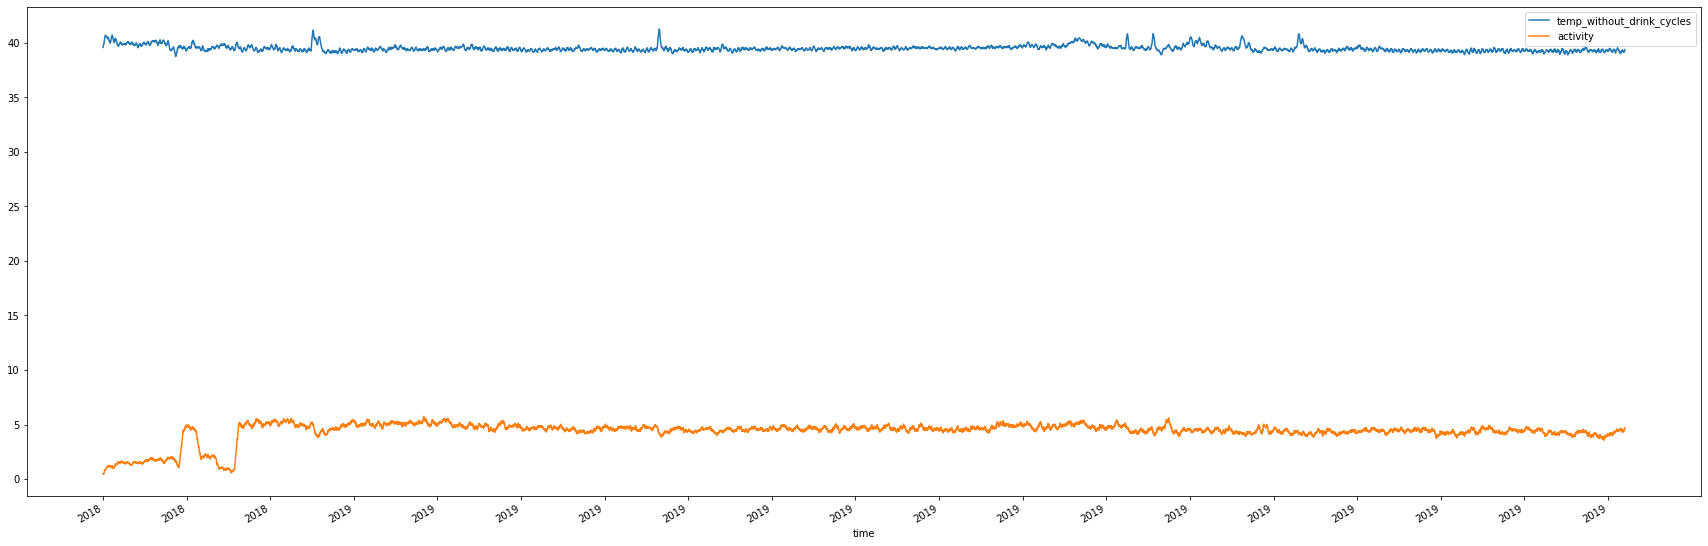

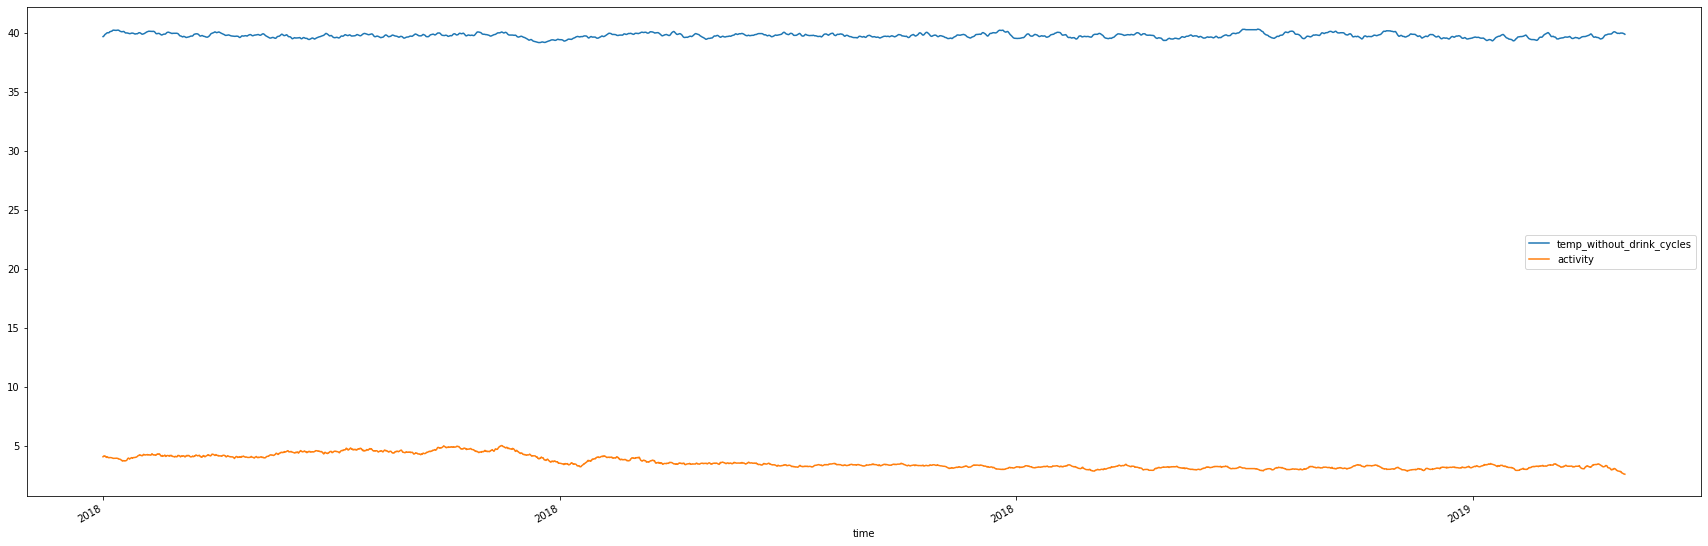

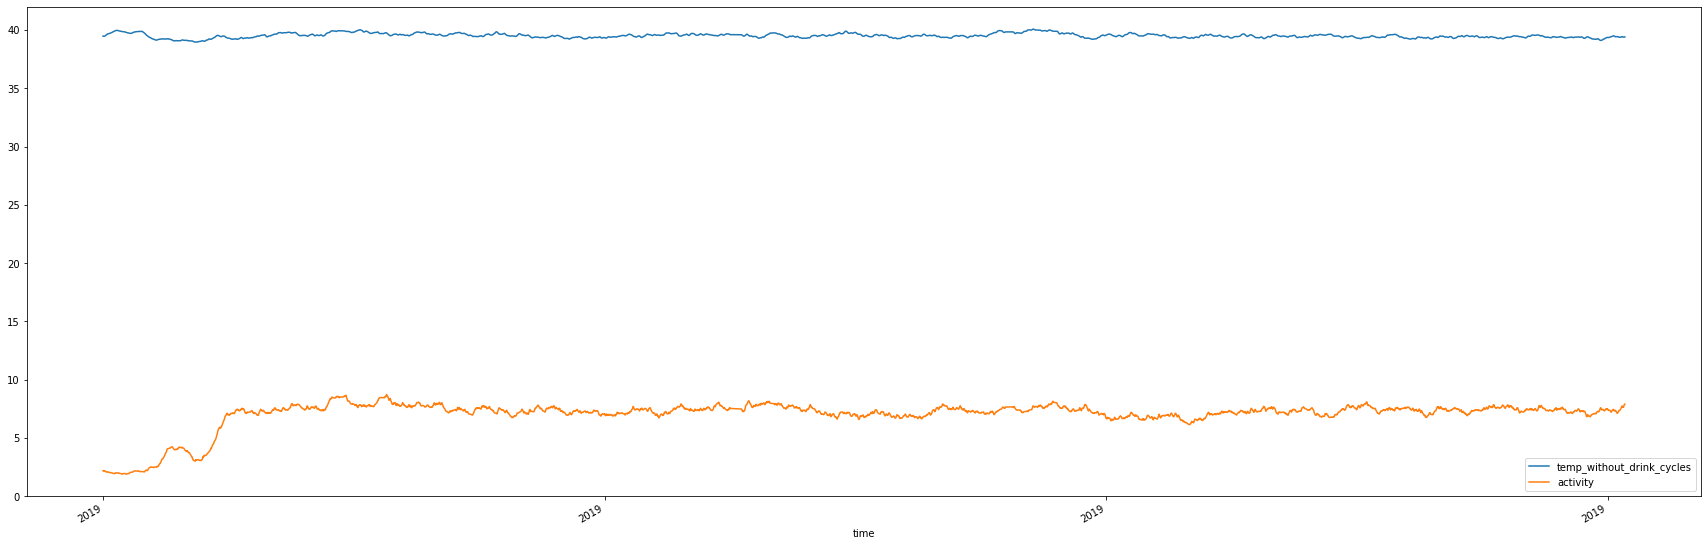

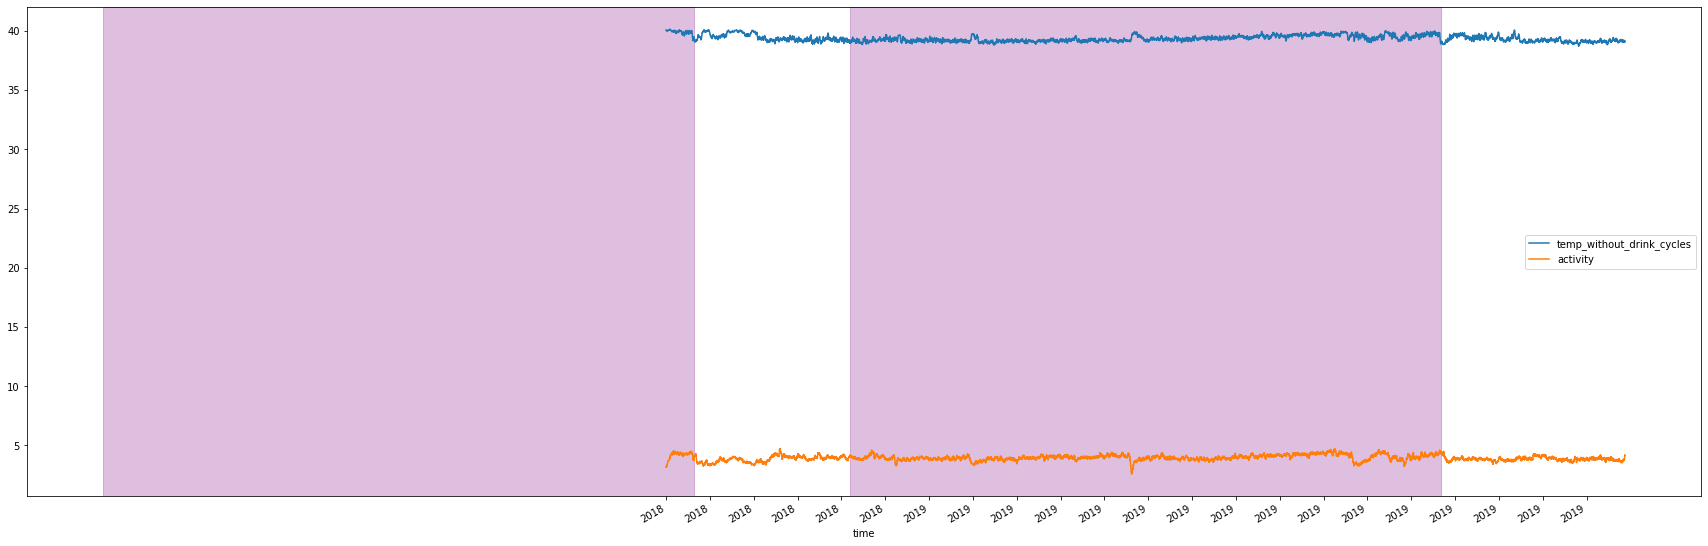

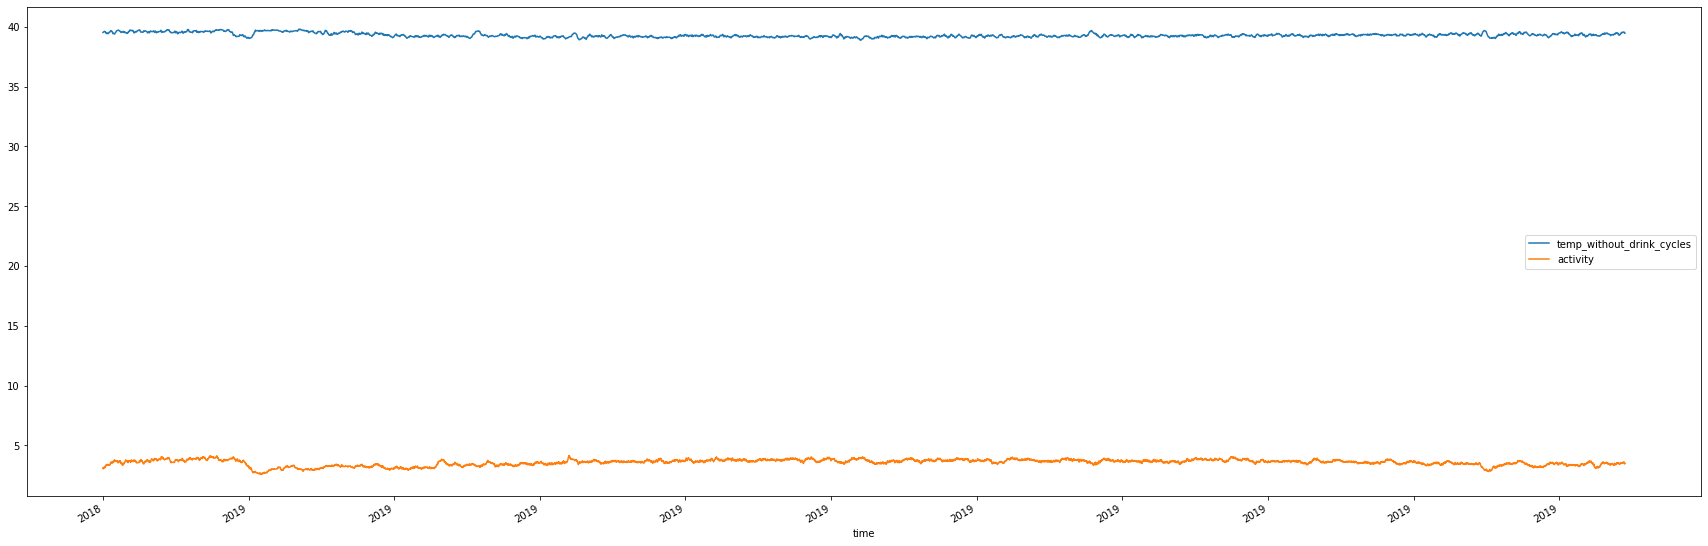

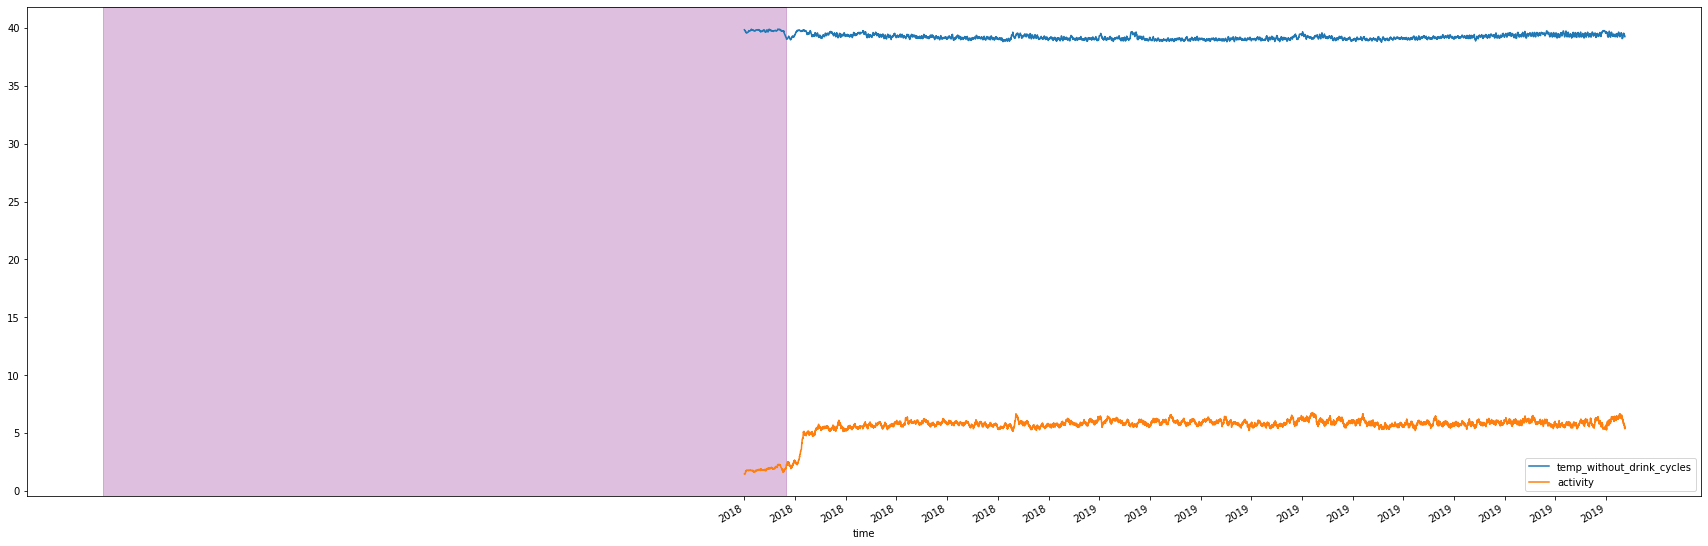

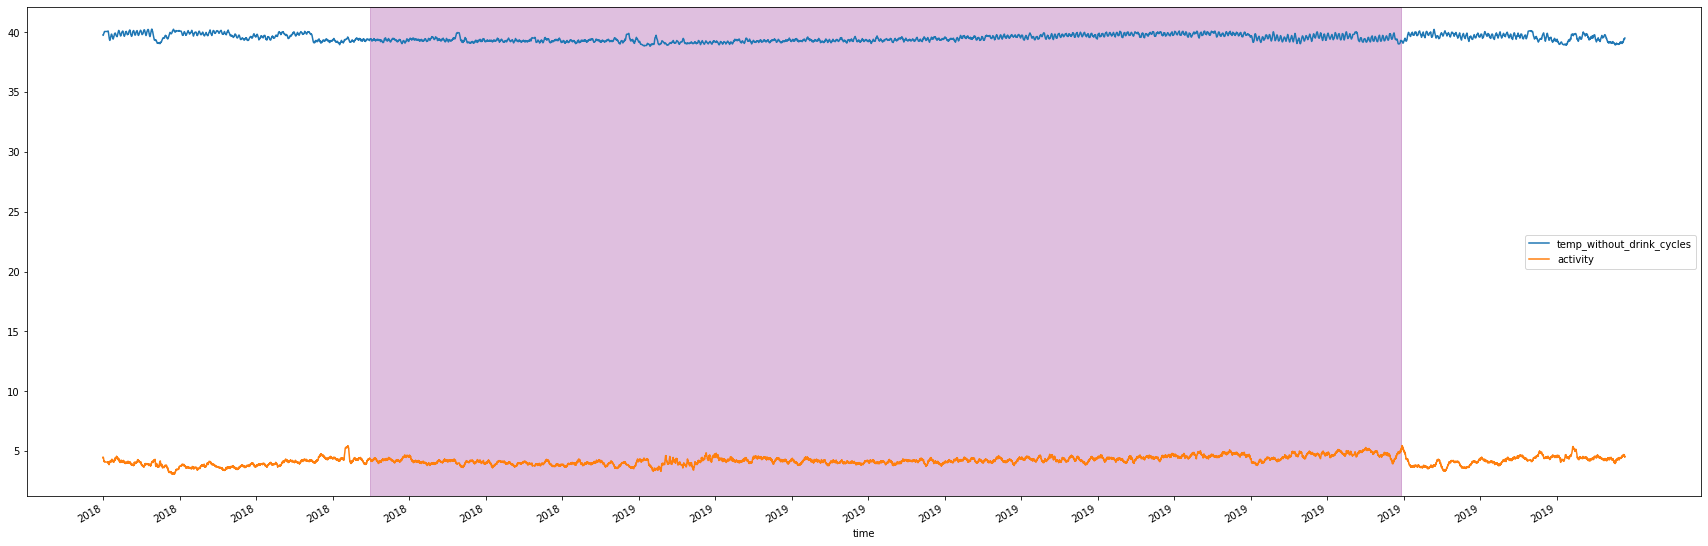

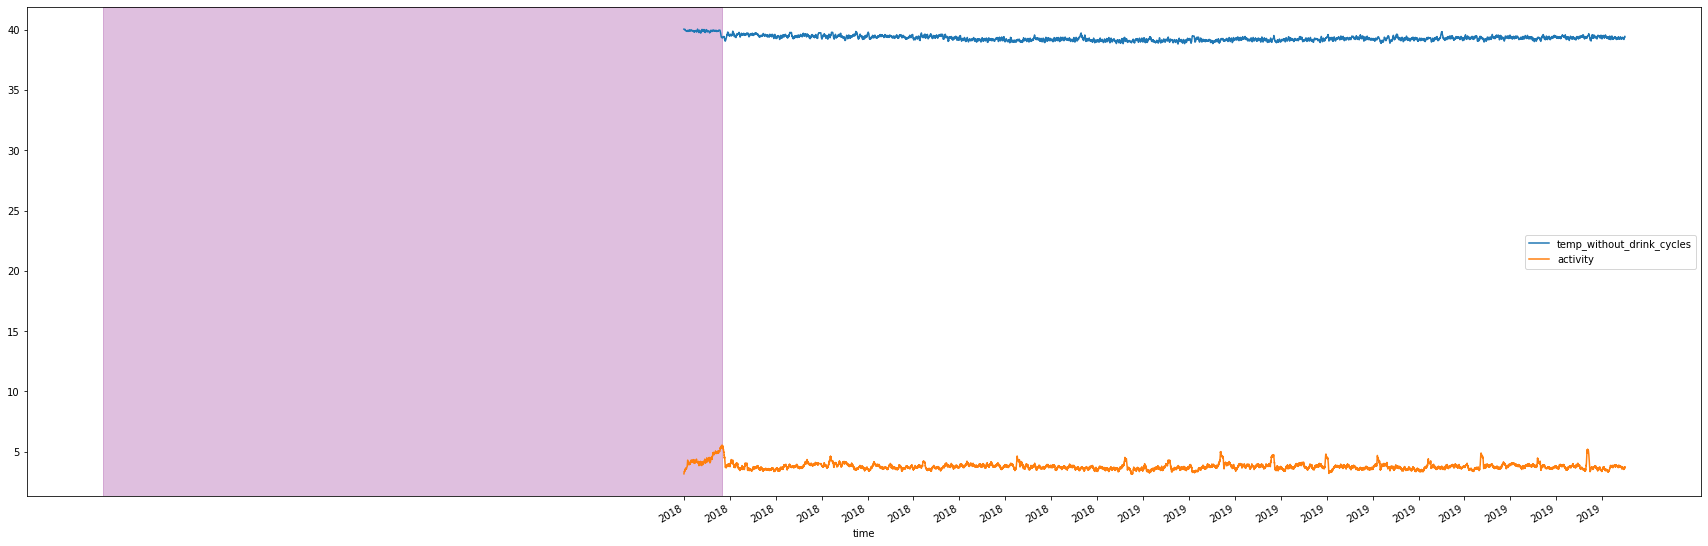

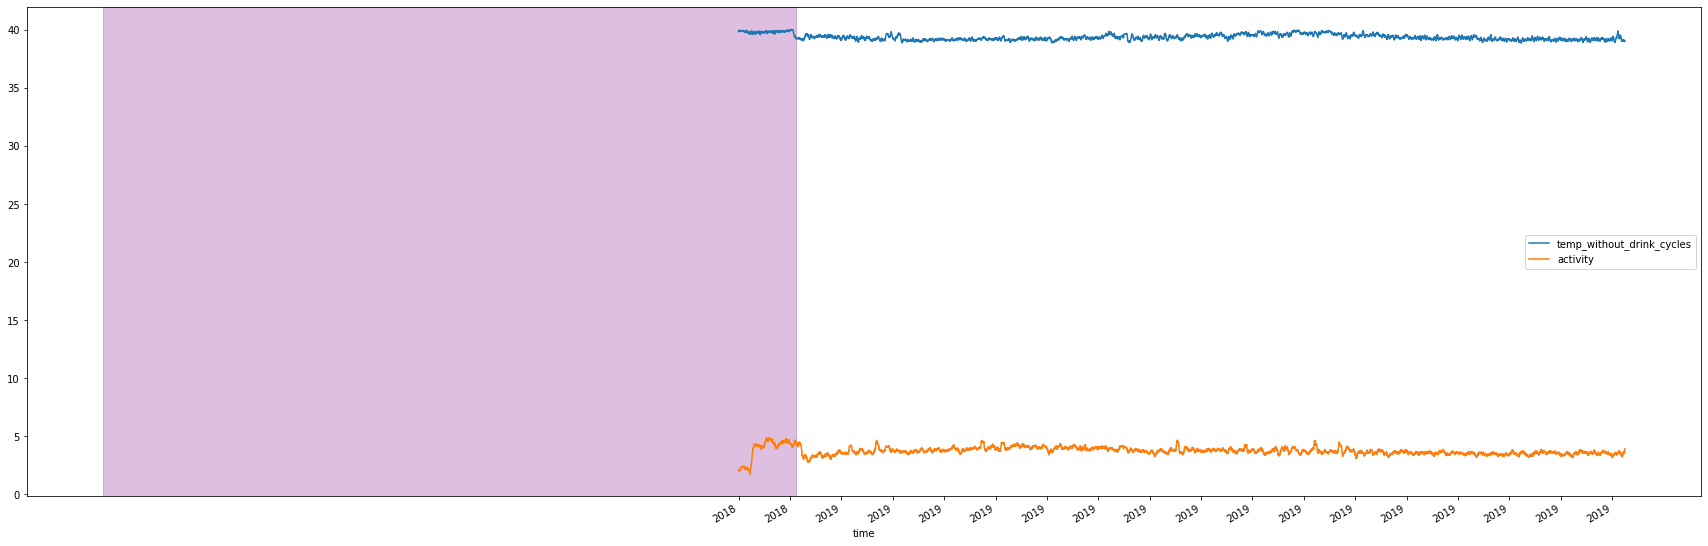

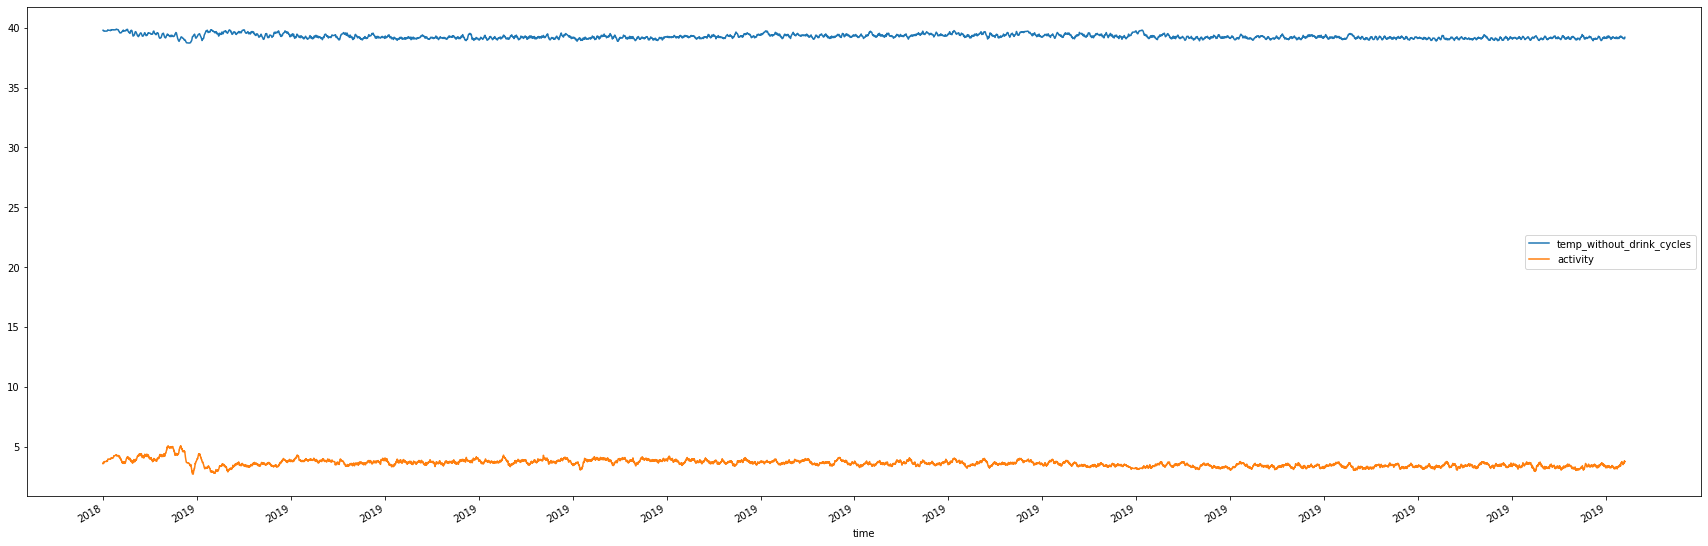

In [46]:
cows = dict()
columns = ['act_heat_index', 'act_heat_index_smart', 'activity', 'heat_index', 'activity_1day_avg', '60percentile_of_5day_temp', 'temp', 'temp_dec_index', 'temp_height_index', 'temp_inc_index', 'temp_without_drink_cycles', 'time', 'cow_id']

for file_name in os.listdir('sample/'):
    if file_name != 'breedings.csv' and file_name.split('.')[1] == 'csv':
        data = pd.read_csv('sample/' + file_name)
        
        data.columns = columns
        data.time = pd.to_datetime(data.time, errors='coerce')
        data = data[~data.activity_1day_avg.isnull()]
        data = data[['activity', 'temp_without_drink_cycles', 'time', 'cow_id']]
        data = data.reset_index(drop=True)
        
        # checks for missing data at beginning/ end and removes it
        for i, row in data[data.time.diff() > pd.Timedelta(hours=1, minutes=10)].iterrows():
            if i < 14*24*6:
                data = data[data.index >= i]
            elif len(df) - i < 14*24*6:
                data = data[data.index < i]

        # removes outliers
        data = data[(data.activity >= data.activity.mean() - 2 * data.activity.std()) & (data.activity <= data.activity.mean() + 2 * data.activity.std())]
        data = data[(data.temp_without_drink_cycles >= data.temp_without_drink_cycles.mean() - 2 * data.temp_without_drink_cycles.std()) & (data.temp_without_drink_cycles <= data.temp_without_drink_cycles.mean() + 2 * data.temp_without_drink_cycles.std())]
        
        data = data.reset_index(drop=True)
        
        # smoothing
        data.temp_without_drink_cycles = data.temp_without_drink_cycles.rolling(12*6, min_periods=1, center=True).mean()
        data.activity = data.activity.rolling(24*6, min_periods=1, center=True).mean()

#         # scaling to a max height of 10
#         data.temp_without_drink_cycles = data.temp_without_drink_cycles / (data.temp_without_drink_cycles.max() - data.temp_without_drink_cycles.min()) * 20
#         data.activity = data.activity / (data.activity.max() - data.activity.min()) * 20

        cow_id = data.cow_id.unique()[0]
        plot_data(data, cow_id)
        cows[cow_id] = data
        data.to_csv('sample cleaned/' + str(cow_id) + '.csv', index=False)
        